The results observed in rs_comparison notebook do not agree with the results presented
in the moment-matching paper. This notebook is for replicating some of the experiments
presented in the paper.

The parameters below are taken from the R implementation by the author. This is the
multivariate normal example.

This implementation very closely follows the author's implementation. Parts of original
R code is given in the comments.

In [1]:
import math
from typing import Tuple
from time import time

import torch
from scipy.stats import norm, t
from torch import Tensor
from torch.distributions import MultivariateNormal

from contextual_rs.unknown_correlation_model import UnknownCorrelationModel

def cov(X: Tensor) -> Tensor:
    r"""
    Estimate the empirical covariance matrix from a `n x d` output matrix.
    Returns the `n x n` empirical covariance matrix.
    """
    assert X.dim() == 2
    mean_ = X.mean(dim=0, keepdim=True)
    normalized_ = X - mean_
    product_ = normalized_.t().matmul(normalized_)
    return product_ / X.shape[0]


class Container:
    def __init__(self, **kwargs):
        r"""
        This is a simple class to facilitate the use of methods defined in
        UnknownCorrelationModel within the script below.
        Fill this with the arguments needed for the method and pass it as self.
        """
        for k, v in kwargs.items():
            setattr(self, k, v)

    def add_full_observations(self, *args, **kwargs):
        UnknownCorrelationModel.add_full_observations(self, *args, **kwargs)

    def update_parameters(self, *args, **kwargs):
        UnknownCorrelationModel.update_parameters(self, *args, **kwargs)

In [2]:
# This part of the code is taken from "parametric_bandit" implementation.
# Slightly modified to work as a function and with T distribution.


def _algorithm_1(a: Tensor, b: Tensor) -> Tuple[Tensor, Tensor]:
    """
    Algorithm 1 from Frazier 2009
    :param a: Input a
    :param b: Input b, in strictly increasing order
    :return: c and A, indices starting with 1 as in original algorithm description!
    """
    # The indices of a and b start with 0, however the rest starts with 1.
    M = a.shape[-1]
    c = torch.empty(M + 1)
    c[0] = -float("inf")
    c[1] = float("inf")
    A = [1]
    for i in range(1, M):
        c[i + 1] = float("inf")
        done = False
        while not done:
            j = A[-1]
            c[j] = (a[j - 1] - a[i]) / (b[i] - b[j - 1])
            if len(A) != 1 and c[j] <= c[A[-2]]:
                A = A[:-1]
            else:
                done = True
        A.append(i + 1)
    return c, torch.tensor(A, dtype=torch.long)


def _f(z: Tensor) -> Tensor:
    """
    The function f defined in the paper as f(z) = phi(z) + z Phi(z) where
    phi and Phi are standard normal PDF and CDF
    :param z: a Tensor of input values
    :return: corresponding f(z) values
    """
    z = z.detach()
    return torch.tensor(norm.pdf(z)) + z * torch.tensor(norm.cdf(z))


def _sigma_tilde(Sigma: Tensor, index: int) -> Tensor:
    """
    Computes sigma_tilde w.r.t the given selection
    :return: sigma_tilde, tensor of size M
    """
    sigma_tilde = Sigma[:, index] / torch.sqrt(self.error + Sigma[index, index])
    return sigma_tilde


def find_maximizer(mu: Tensor, Sigma: Tensor):
    """
    Runs Algorithm 2 as described in the paper.
    This is for multivariate normal posterior. A slightly modified
    version is given below for use with multivariate T posterior.

    :param mu: mean vector, tensor of size M
    :param Sigma: covariance matrix, tensor of size M x M
    :return: argmax KG(i) or argmin KG(i) if minimize
    """
    mu = mu.reshape(-1)
    M = mu.shape[0]
    # algorithm loop
    v_star = -float("inf")
    x_star = None
    for i in range(M):
        a = mu
        b = _sigma_tilde(Sigma, i)
        # sort a, b such that b are in non-decreasing order
        # and ties in b are broken so that a_i <= a_i+1 if b_i = b_i+1
        b, index = torch.sort(b)
        a = a[index]
        # handle ties in b, sort a in increasing order if ties found
        if torch.any(b[1:] == b[:-1]):
            for j in range(M):
                a[b == b[j]], _ = torch.sort(a[b == b[j]])
        # remove the redundant entries as described in the algorithm
        remaining = torch.ones(M, dtype=torch.bool)
        remaining[torch.cat([b[1:] == b[:-1], torch.tensor([False])], dim=0)] = 0
        a = a[remaining]
        b = b[remaining]
        # c and A has indices starting at 1!
        c, A = _algorithm_1(a, b)
        b = b[A - 1]
        c = c[A]
        # TODO: this value part needs to change
        v = torch.log(torch.sum((b[1:] - b[:-1]) * _f(-torch.abs(c[:-1]))))
        if i == 0 or v > v_star:
            v_star = v
            x_star = i
    return x_star


def selectx(q: float, b: float, theta: Tensor, B: Tensor, method: str) -> int:
    """
    Runs Algorithm 2 as described in the paper.
    This is for the multivariate T posterior.
    """
    r"""
    K<-length(theta)
    if(method==1|method==2) {
    df=b-K+1
    qk=(q+1)/(q*(b-K+1))
        if(method==1) { #qu's select
            #b^(n+1)=b^n+1/K
            S0=sqrt(qk)/(q*(b+1/K)/(b+1/K-K+1)+1)
        }
        if(method==2) { #proposed select
            S0=1/sqrt((q+1)*q*(b-K+1))
        }
        alpha=theta
        #vs:a vector collect value of informations
        vs=c()
        for(x in 1:K) {
            S<-S0/sqrt(B[x,x])*B[,x]
            beta<-S
            stopifnot(sum(S==S[1])<length(S))
            re<-subway(alpha,beta)
            cc<-re$cc
            idx<-re$idx
            bb<-re$b[idx]
            bdeltavalue<-bb[-1]-bb[-c(length(bb))]
            expectedvalues<-dt(abs(cc),df)*(df+cc^2)/(df-1)
            expectedvalues<-expectedvalues-abs(cc)*(1-pt(abs(cc),df))
            vs=c(vs,sum(bdeltavalue*expectedvalues))
        }
        xopt=which.max(vs)
    """
    df = b - K + 1
    qk = (q+1)/(q*df)
    if method == "KL":
        S0 = math.sqrt(qk)/(q*(b + 1.0/K)/(b + 1.0/K - K + 1) +1)
    else:
        S0 = 1.0/math.sqrt((q+1) * q * df)
    # algorithm loop
    v_star = -float("inf")
    x_star = None
    for i in range(K):
        a = theta
        b = S0 / B[i, i].sqrt() * B[:, i]
        # sort a, b such that b are in non-decreasing order
        # and ties in b are broken so that a_i <= a_i+1 if b_i = b_i+1
        b, index = torch.sort(b)
        a = a[index]
        # handle ties in b, sort a in increasing order if ties found
        if torch.any(b[1:] == b[:-1]):
            for j in range(K):
                a[b == b[j]], _ = torch.sort(a[b == b[j]])
        # remove the redundant entries as described in the algorithm
        remaining = torch.ones(K, dtype=torch.bool)
        remaining[torch.cat([b[1:] == b[:-1], torch.tensor([False])], dim=0)] = 0
        a = a[remaining]
        b = b[remaining]
        # c and A has indices starting at 1!
        c, A = _algorithm_1(a, b)
        b = b[A - 1]
        c = c[A[:-1]].abs()
        # Replacing this v calculation with one from R code
        # v = torch.log(torch.sum((b[1:] - b[:-1]) * _f(-torch.abs(c[:-1]))))
        b_delta = b[1:] - b[:-1]
        expected_values = torch.tensor(t.pdf(c, df)) * (df + c.pow(2)) / (df - 1) - (
            c * (1 - torch.tensor(t.cdf(c, df)))
        )
        # TODO: b_delta and expected_values shapes do not match
        v = (b_delta * expected_values).sum()
        if i == 0 or v > v_star:
            v_star = v
            x_star = i
    return x_star


def fullyrs(W, b0, q0, B0, theta0, method):
    """
    fullyrs<-function(W,b0,q0,B0,theta0,selectmethod,updatemethod) {
      #update one alternative a time
      b=b0
      q=q0
      theta=theta0
      B=B0
      #thetas:matrix to collect updated mean in each step
      thetas=matrix(0,0,K)
      #xs:vector to collect selected alternative in each step
      xs<-c()
      #dbs: vector to collect increasing step of b in each step
      dbs<-c()
      #Bs: list to collect B in each step
      Bs<-list()
      for(i in 1:nrow(W)) {
          x<-selectx(q,b,theta,B,B0/(b0-K-1),selectmethod)
          xs<-c(xs,x)
          Y=W[i,]
          results=update(x,q,b,theta,B,B0/(b0-K-1),Y,updatemethod)
          q=results$q
          b=results$b
          theta=results$theta
          dbs<-c(dbs,results$db)
          B<-results$B
          Bs[[i]]<-B
          thetas <- rbind(thetas,theta)
      }
      rownames(thetas)=1:nrow(W)
      thetas=melt(thetas)
      names(thetas)<-c("step","alternative","value")
      thetas$selectmethod<-selectmethod
      thetas$updatemethod<-updatemethod
      return(list(thetas=thetas,Bs=Bs,dbs=dbs,xs=xs,b=b,q=q))
    """
    b = b0
    q = q0
    theta = theta0.clone()
    B = B0.clone()
    thetas = list()
    xs = list()
    Bs = list()
    for i in range(W.shape[0]):
        x = selectx(q, b, theta, B, method)
        xs.append(x)
        Y = W[i]
        container = Container(
            q=q, b=b, theta=theta, B=B, num_alternatives=K, update_method=method
        )
        container.update_parameters(
            X=torch.tensor(x),
            Y=Y[x],
        )
        q = container.q
        b = container.b
        theta = container.theta
        B = container.B
        Bs.append(B.clone())
        thetas.append(theta.clone())
    return thetas, Bs, xs, b, q

In [7]:
K = 10
rho = 0.5
replications = 20   # number of replications
N = min(K*100,1000)
# number of samples: use a matrix to store a vector at each iteration
burn = K+3+10  # warmup sample same propotion as Qu et al
# burn need to be > K+2 (b/c update formula in proposition 3)

#prior
b0 = burn - 1  # number of sample used to estimate B
q0 = b0

methods = [
    "KL", "moment-matching", "moment-KL"
]

# bs<-matrix(0,nrow(methods),IT) # final b for each method in each replication
# qs<-matrix(0,nrow(methods),IT) # final q for each method in each replication
# xsall<-list() # selected x in the all replications
bs = torch.zeros(len(methods), replications)
qs = torch.zeros(len(methods), replications)
xsall = list()

# R code for generating the samples
# Wall<-genW(N+burn,K,datacase,rho)
#   thetat<-seq(0,1,len=K)             #mean of multivariate normal
#   Sigma<-toeplitz(rho^seq(0,K-1,1))         #covariance matrix
#   W<-matrix(rnorm(N*K),N,K)%*%chol(Sigma)
#   W<-W+matrix(thetat,N,K,byrow=T)

# replicated as a torch MultivariateNormal object:
true_mean = torch.linspace(0, 1, K)
true_cov = torch.zeros(K, K)
for i in range(K):
    for j in range(K):
        true_cov[i, j] = torch.tensor(rho).pow(abs(i - j))
true_mvn = MultivariateNormal(true_mean, true_cov)

start = time()

all_thetas = list()
for rep in range(replications):
    print(f"Starting rep {rep}, time: {time() - start}")
    W_all = true_mvn.rsample(torch.Size([N+burn])).detach()
    W_burn = W_all[:burn, :]
    theta0 = W_burn.mean(dim=0)
    # B0<-cov(Wburn)*(b0-K-1)
	# ESigma<-array(B0/(b0-K-1),dim=c(K,K,nrow(methods)+2)) #resulted variances results
    # This is a K x K x (num_methods + 2) array.
    # It is simply the input matrix repeated num_methods + 2 times.
    # As with Tensor conventions, we will keep the num_methods + 2 dim on the outside
    # Ignore +2 as those are for full observations and for independent model.
    B0 = cov(W_burn) * (b0 - K - 1)
    ESigma = (B0/(b0-K-1)).expand(len(methods), -1, -1)

    # W<-Wall[-(1:burn),] #generate sample: a N*K matrix
    # results<-fullyall(W,b0,q0,B0,theta0) #fully update
    # mus<-results$theta #will be used for computing opportunity cost
    # #mus<-apply(W,2,mean)
    # ESigma[,,2]<-results$B/(b0+N-K-1)# since update all, the last b is b0+N
    # This is for having a benchmark that has full observations. We can skip this.

    W = W_all[burn:]
    xsall.append(list())
    results_list = list()
    for case, method in enumerate(methods):
        results = fullyrs(W, b0, q0, B0, theta0, method)
        ESigma[case] = results[1][-1] / (results[3] - K - 1)
        bs[case, rep] = results[3]
        qs[case, rep] = results[4]
        xs = torch.tensor(results[2])
        xsall[rep].append(xs)
        results_list.append(results[0])
    all_thetas.append(results_list)

Starting rep 0, time: 0.0006039142608642578
Starting rep 1, time: 27.809241771697998
Starting rep 2, time: 54.45228099822998
Starting rep 3, time: 81.53418493270874
Starting rep 4, time: 107.89788269996643
Starting rep 5, time: 134.21172881126404
Starting rep 6, time: 160.47123885154724
Starting rep 7, time: 186.92614769935608
Starting rep 8, time: 213.34329390525818
Starting rep 9, time: 239.77997279167175
Starting rep 10, time: 266.15881276130676
Starting rep 11, time: 292.43635988235474
Starting rep 12, time: 319.16035509109497
Starting rep 13, time: 345.4906749725342
Starting rep 14, time: 372.11867904663086
Starting rep 15, time: 398.2921347618103
Starting rep 16, time: 424.7879250049591
Starting rep 17, time: 451.2918059825897
Starting rep 18, time: 477.6332709789276
Starting rep 19, time: 504.156281709671


/opt/anaconda3/envs/contextual_rs/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:5982: RuntimeWarning: overflow encountered in power
  Px /= np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)
/opt/anaconda3/envs/contextual_rs/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:5982: RuntimeWarning: overflow encountered in multiply
  Px /= np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)


In [12]:
argmax_thetas = [
    [
        [
            all_thetas[i][j][k].argmax() for k in range(N)
        ] for j in range(3)
    ] for i in range(replications)
]

In [13]:
argmax_evals = [
    [
        true_mean[argmax_thetas[i][j]] for j in range(3)
    ] for i in range(replications)
]

In [15]:
avg_evals = [
    torch.cat(
        [argmax_evals[i][j].unsqueeze(0) for i in range(replications)],
        dim=0
    ).mean(dim=0) for j in range(3)
]

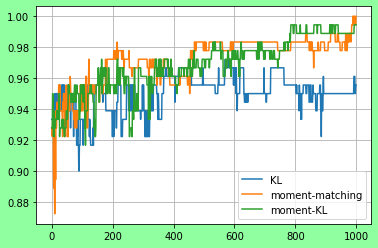

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.patch.set_facecolor('xkcd:mint green')

for i in range(3):
    plt.plot(avg_evals[i], label=methods[i])
plt.legend()
plt.grid()